## FORECASTING THE VOLATILITY INDEC USING ARIMA MODELING

The CBOE VIX is a crucial indicator of expected market volatility. It reflects the collective sentiment of investors regarding future market fluctuations, as inferred from the price of 'put' and 'call' options on the S&P 500 Index.

This project utilizes historical CBOE Volatility Index data to analyze trends in market volatility over time. The VIX provides insights into expected market movements. By applying time series techniques, the aim is to forecast future VIX values, thereby predicting potential shifts in market sentiment and risk levels.


In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests

### Loading the dataset
The dataset is updated daily, which ensures that the model's predictions are based on the more recent market conditions.

In [182]:
url = 'https://raw.githubusercontent.com/datasets/finance-vix/main/data/vix-daily.csv'

response = requests.get(url)
with open('vix_data.csv', 'wb') as file:
    file.write(response.content)
vix_data = pd.read_csv('vix_data.csv')

In [183]:
print(vix_data.columns)

Index(['DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE'], dtype='object')


In [184]:
vix_data.set_index('DATE', inplace = True)
vix_data.index = pd.to_datetime(vix_data.index)

In [185]:
vix_data.head()

,OPEN,HIGH,LOW,CLOSE
DATE,,,,
1990-01-02,17.24,17.24,17.24,17.24
1990-01-03,18.19,18.19,18.19,18.19
1990-01-04,19.22,19.22,19.22,19.22
1990-01-05,20.11,20.11,20.11,20.11
1990-01-08,20.26,20.26,20.26,20.26


In [186]:
vix_data.tail()

,OPEN,HIGH,LOW,CLOSE
DATE,,,,
2024-08-16,15.29,15.76,14.65,14.80
2024-08-19,15.94,16.07,14.46,14.65
2024-08-20,14.89,15.93,14.78,15.88
2024-08-21,16.25,17.17,15.92,16.27
2024-08-22,16.27,18.06,15.76,17.55


### Analyzing VIX

The yearly average of the VIX is plotted to observe long-term trends in market volatility.()

<Axes: xlabel='DATE', ylabel='CLOSE'>

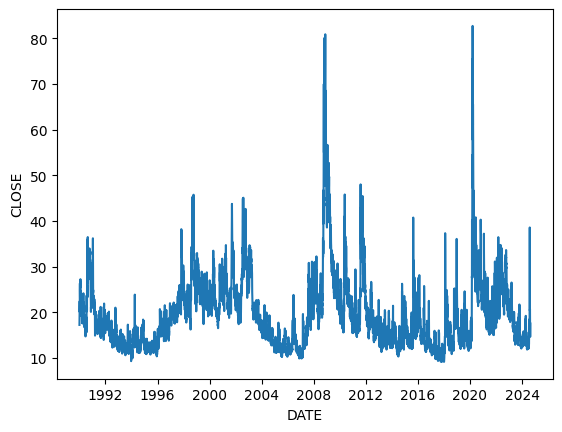

In [187]:
yearwise = vix_data['CLOSE'].resample('Y').mean()
sns.lineplot(data=vix_data, x=vix_data.index, y='CLOSE')

### Stationarity Check 
Statistical properties - mean, variance, and covariance of the dependent variable - of a time series that has stationarity are constant over time


#### AUGMENTED DICKEY-FULLER TEST

The ADF test is used to test the null hypothesis that a unit root is present in a time series, which implies that the series is non-stationary.
For the analysis, the 'autolag; parameter is set to 'AIC' to allow the test to automatically select the lag length that minimizes the Akaike Information Criterion (AIC).

In [188]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(vix_data['CLOSE'], autolag= 'AIC')
adf

(-6.968730755477114,
 8.776555251210055e-10,
 10,
 8729,
 {'1%': -3.4310993669444065,
  '5%': -2.86187117030305,
  '10%': -2.566946276984866},
 33001.16885607586)

In [189]:
adf_stats = pd.Series(adf[0:4], index = ['ADF Statistics:', 'p-value:','Lags Used:','Number of Observations:'])
adf_stats

ADF Statistics:           -6.968731e+00
p-value:                   8.776555e-10
Lags Used:                 1.000000e+01
Number of Observations:    8.729000e+03
dtype: float64

In [190]:
for key, values in adf[4].items():
    print("Critical Values:"
         f'\t{key}:{values}')

Critical Values:	1%:-3.4310993669444065
Critical Values:	5%:-2.86187117030305
Critical Values:	10%:-2.566946276984866


Given that the test statistics is significantly lower than the critical values at 1%, 5%, and 10% levels, and the p-value is effectively 0, reject the null hypothesis.

This indicates that the VIX series is stationary.

### ARIMA Model Selection 
Autocorrelation and Partial Autocorrelation Analysis are used to determine the appropriate parameters for the ARIMA model.

#### Autocorrelation and Partial Autocorrelation Analysis

Analyzing ACF plot gives the MA(q) component by showing the correlation of the series with lagged values, and PACF gives the AR(p) component by showing the partial correlation of the series with its lags, after removing the influence of earlier lags.

In [192]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

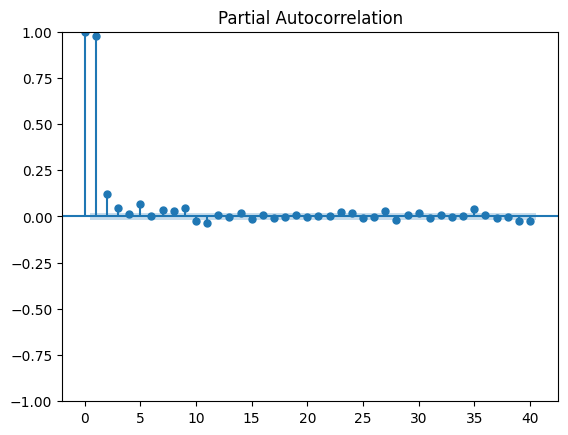

In [227]:
plot_pacf(vix_data['CLOSE'], lags = 40)
plt.show()

The PACF plot shows a spike at 1, after which the values decay to zero, and hence p=1.

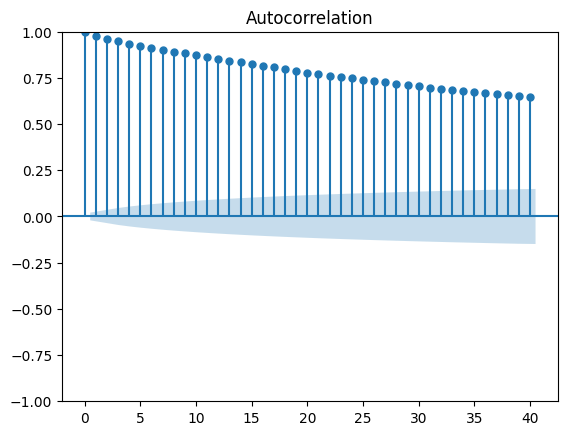

In [226]:
plot_acf(vix_data['CLOSE'], lags = 40)
plt.show()

The ACF plot exhibits a slow decay, suggesting that each observation is correlated with previous ones. This indicates a higher-order MA, hence q = 2.

### Building ARIMA model
Using the selected 'p', 'd', and 'q' values, the next step is to build an ARIMA model. Since the series is stationary based on the ADF test, d will be 0.

In [195]:
from statsmodels.tsa.arima.model import ARIMA

In [196]:
#80% training, 20% testing
split_point = int(len(vix_data) *0.8)
train = vix_data['CLOSE'][:split_point]
test = vix_data['CLOSE'][split_point:]

In [219]:
model = ARIMA(train, order = (1,0,2))
model_fit = model.fit()
model_fit.summary()

C:\Users\jiyas\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jiyas\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jiyas\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  CLOSE   No. Observations:                 6992
Model:                 ARIMA(1, 0, 2)   Log Likelihood              -12740.037
Date:                Fri, 23 Aug 2024   AIC                          25490.074
Time:                        17:04:29   BIC                          25524.337
Sample:                             0   HQIC                         25501.881
                               - 6992                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.4149      1.623     11.963      0.000      16.234      22.596
ar.L1          0.9885      0.001   1064.962      0.000       0.987       0.990
ma.L1         -0.1109      0.005    -20.338      0.000      -0.122      -0.100
ma.L2         -0.0979      0.004    -23.564      0.000      -0.106      -0.090
sigma2         2.2385      0.013    172.178      0.000       2.213       2.264
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):             90855.61
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               2.69   Skew:                             1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [220]:
predictions = model_fit.forecast(steps=len(test))
print(predictions)

6992     9.756592
6993     9.870915
6994     9.980949
6995    10.089714
6996    10.197226
          ...    
8735    19.414885
8736    19.414885
8737    19.414885
8738    19.414885
8739    19.414885
Name: predicted_mean, Length: 1748, dtype: float64


C:\Users\jiyas\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\jiyas\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Model Evaluation
Calculate the Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) to evaluate the model's performance

In [222]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

Mean Absolute Error (MAE): 5.256652762990841
Root Mean Squared Error (RMSE): 7.686231897992504


In [ ]:
mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

### Residual Analysis
Residual are the differences between the observed values and the values predicted by the model. Analyzing the residuals allows to check whether the model has captured the data's underlying structure adquately.

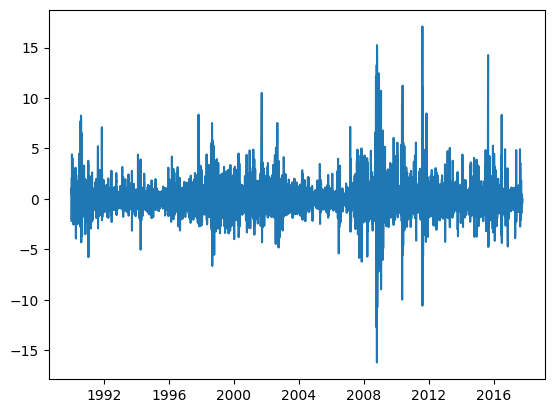

In [224]:
residuals = model_fit.resid
plt.plot(residuals)
plt.show()

#### Residual plot

The notable spikes are observed during known periods of market stress, like the 2008 financial crisis. These spikes indicate times when the model's predictions deviated more significantly from the actual VIX values, likely due to the extreme market conditions that are difficult for any model to predict accurately.

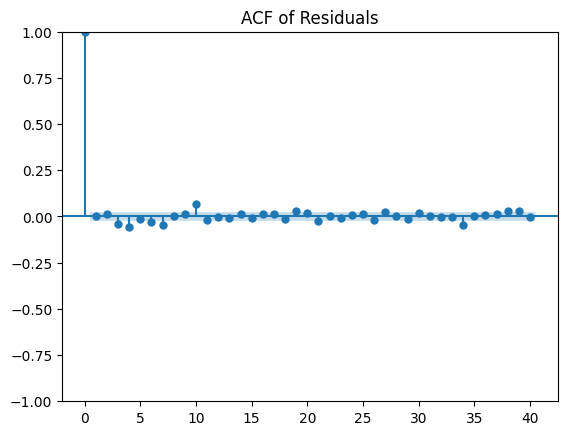

In [225]:
plot_acf(residuals, lags=40)
plt.title('ACF of Residuals')
plt.show()

The ACF plot of the residuals supports the conclusion that the ARIMA (1,0,2) model has successfully captured the underlying time series structure. The near-zero autocorrelations (apart from the one at lag 1, which is expected) indicate that the residuals do not exhibit any patterns that the model failed to capture